<a href="https://colab.research.google.com/github/bartk97/numercial-methods-for-SDEs/blob/master/Projekt_SIS_model_epidemiologiczny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model epidemiologiczny SIS z dwoma niezależnymi procesami Wienera**

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

### **Wstęp**

W moim projekcie będę zajmował się rozwiązaniem numerycznym nieco zmodyfikowanego modelu epidemiologicznego ***modelu SIS (susceptible - 
infected - susceptible)***, którego założeniem jest brak nabywania odporności. Modyfikacja klasycznego modelu SIS polega na dodaniu zaburzeń w postaci dwóch składników z niezależnymi procesami Wienera. Celem zagadnienia jest przewidzenie końcowego efektu wybuchu epidemii, może
ona: wygasnąć lub ustalić się na stałym poziomie, co nazywamy
pandemią.

**Opis matematyczny:**

Niech $W_1, W_2$ będą dwoma niezależnymi procesami Wienera określonymi na pewnej przestrzeni probabilistycznej. Poprzez $N$ będę oznaczał stałą liczebność populacji (rodzi się tyle samo osobników co umiera), natomiast poprzez $I$ liczbę osobników zainfekowanych. Parametry $\beta, \gamma, \mu, \sigma_1, \sigma_2 >0$, to pewne współczynniki wpływające na przebieg epidemii. Wówczas rozpatrywany model SIS opisany jest następującym stochastycznym równaniem różniczkowym:

$$dI(t) = [\beta (N - I(t))I(t) - (\mu + \gamma)I(t)]dt + \sigma_1 I(t)(N- I(t))dW_1(t) - \sigma_2 I(t)\sqrt{N-I(t)}dW_2(t)$$

z warunkiem początkowym $I(0) \in (0, N)$.


In [ ]:
# funkcje przy dt, dW1, dW2
def a_SIS(t, I):
    return beta*(N - I)*I - mu_gamma*I
def b1_SIS(t, I):
    return sigma_1*I*(N - I)
def b2_SIS(t, I):
    return -sigma_2*I*np.sqrt(N - I)

**Twierdzenie** *(Istnienie i jedyność rozwiązania)*

Jeśli $\mu + \gamma \geq \frac{1}{2}\sigma_2^2 N$, to dla dowolnego warunku początkowego $I(0) \in (0, N)$ powyższe stochastyczne równanie różniczkowe ma dokładnie jedno rozwiązanie $I(t) \in (0, N)$ dla każdego $t \geq 0$ z prawdopodobieństwem jeden.

Dla ułatwienia przyjmę $N=1$ i będę interpretował to jako przeskalowany problem na przedział $[0,1]$.

##### **Kod - funkcje pomocnicze:**

In [ ]:
# rysowanie 'm' trajektorii rozwiazania przybliczonego metoda 'scheme'
# dla danych 'T, I_0, a, b_1, b_2, n'
def plot_paths(T, I_0, a, b_1, b_2, n, scheme, m):
    plt.figure(figsize=(8,5))
    for i in range(m):
        Time, I = scheme(T, I_0, a, b_1, b_2, n)
        plt.plot(Time, I, label = 'path ' + str(i+1))
    plt.title('Solution of SDE')
    plt.legend()
    plt.show()

# wyliczanie tempa zbieznosci oraz rysowanie wykresu z regresja 
# test dla danych 'T, X_0, a, b_1, b_2'
# m - roznych ilosci wezlow n = 10*2^i dla i = 1,2,..,m
# liczona srednia dla k trajektroii
def slope(T, X_0, a, b_1, b_2, scheme, k, m):
    Mean_Error=[]

    for i in range(1, m):
        n = 10*2**i
        Error = []
        for j in range(k):
            error = scheme(T, X_0, a, b_1, b_2, n, 100)
            Error.append(error)
        Mean_Error.append(np.mean(Error))

    logError = np.log(Mean_Error)
    N = np.array(range(1, m)).reshape((-1, 1))

    model = LinearRegression().fit(N, logError)

    intercept = logError[0]
    slope = model.coef_[0]
    line = lambda x: slope*x + intercept
    L=[line(x) for x in N]

    plt.figure(figsize=(8,6))
    plt.plot(N, logError, 'ro', label = 'LogError')
    plt.plot(N, L, '--', color='grey', label = 'Linear Regression')
    plt.legend()
    plt.show()
    print('\n\nslope = ', slope)

### **Schemat Eulera**

Niech $n \in \mathbb{N}, h = \frac{T}{n}, t_k = kh$ dla $k=0,1,\ldots, n$.  Wówczas $\bar X(0)$ losujemy z rozkładu takiego jaki ma warunek poczatkowy i  dla $k=0,1,\ldots n-1$ przyjmujemy

$$\bar X(t_{k+1}) = \bar X(t_k) + a(t_k, \bar X(t_k))h + b_1(t_k, \bar X(t_k)) Z_k^1 h^\frac{1}{2} + b_2(t_k, \bar X(t_k)) Z_k^2 h^\frac{1}{2}, \quad k=0,1,\ldots n-1,$$

gdzie dla $k=0,1,\ldots n-1$

*   $Z_k^1, Z_k^2$ to dwie zmienne losowe z rozkładu $N(0,1),$

*   wszystkie wyżej wymienione zmienne losowe są od siebie niezależne.


##### **Kod - schemat Eulera:**

In [ ]:
# schemat eulera zwracajacy dwie tablice - t, X(t)
def euler_scheme(T, X_0, a, b_1, b_2, n):
    h = float(T/n)
    h_sqrt = np.sqrt(h)

    Time = np.zeros(n+1)
    Time[0] = 0

    X = np.zeros(n+1)
    X[0] = X_0

    for i in range(n):
        Time[i+1] = Time[i] + h

        dW1 = h_sqrt*np.random.normal(0,1)
        dW2 = h_sqrt*np.random.normal(0,1)
        X[i+1] = X[i] + a(Time[i], X[i])*h + b_1(Time[i], X[i])*dW1 + b_2(Time[i], X[i])*dW2
    
    return Time, X

In [ ]:
# funkcja liczaca blad schematu eulera, gdy nieznane jest rozwiazanie dokladne
def euler_scheme_error(T, X_0, a, b_1, b_2, n, N): 
    h = float(T/n) # podzial przedzialu na n punktow
    h_sqrt = np.sqrt(h)

    h_dense = float(h/N) # podzial siatki n na N punktów, czyli ostatecznie n*N punktow
    h_dense_sqrt = np.sqrt(h_dense)

    t = 0. # czas na siatce rzadkiej
    t_temp = 0.

    t_dense = 0. # czas na siatce gęstej
    t_dense_temp = 0.

    X = X_0 # rozwiązanie na siatce rzadniej
    X_temp = X_0

    X_dense = X_0 # rozwiązanie na siatce gęstej
    X_dense_temp = X_0

    W1_temp = 0.
    W1 = 0. # bieżąca wartość procesu Wienera W1

    W2_temp = 0.
    W2 = 0. # bieżąca wartość procesu Wienera W2

    for i in range(1, n + 1):
        for j in range(1, N + 1):
            t_dense = t + h_dense*j

            dW1 = np.random.normal(0, h_dense_sqrt)
            dW2 = np.random.normal(0, h_dense_sqrt)
            W1 += dW1
            W2 += dW2

            X_dense = X_dense_temp + a(t_dense_temp, X_dense_temp)*h_dense + b_1(t_dense_temp, X_dense_temp)*dW1 + b_2(t_dense_temp, X_dense_temp)*dW2
            X_dense_temp = X_dense

            t_dense_temp = t_dense

        t = i*h
        dW1 = W1 - W1_temp
        dW2 = W2 - W2_temp

        X = X_temp + a(t_temp, X_temp)*h + b_1(t_temp, X_temp)*dW1 + b_2(t_temp, X_temp)*dW2
        X_temp = X

        t_temp = t
        W1_temp = W1
        W2_temp = W2

    return abs(X - X_dense)

##### **Tempo zbieżności**

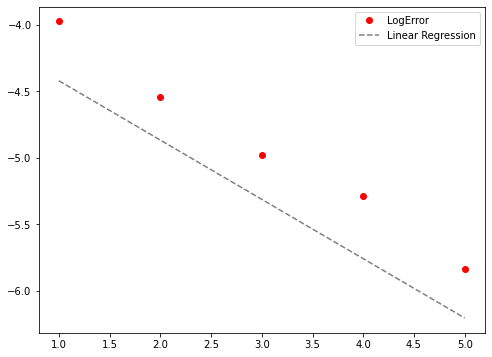



slope =  -0.44548382557716565


In [ ]:
beta = 0.8
mu_gamma = 0.6
sigma_1 = 0.05
sigma_2 = 0.3
N = 1

T = 20
I_0 = 0.6

slope(T , I_0, a_SIS, b1_SIS, b2_SIS, euler_scheme_error, 100, 6)

### **Zrandomizowany schemat Eulera**

Niech $n \in \mathbb{N}, h = \frac{T}{n}, t_k = kh$ dla $k=0,1,\ldots, n$.  Wówczas $\bar X(0)$ losujemy z rozkładu takiego jaki ma warunek poczatkowy i  dla $k=0,1,\ldots n-1$ przyjmujemy

$$\bar X(t_{k+1}) = \bar X(t_k) + a(\tau_k, \bar X(t_k))h + b_1(t_k, \bar X(t_k)) Z_k^1 h^\frac{1}{2} + b_2(t_k, \bar X(t_k)) Z_k^2 h^\frac{1}{2},$$


gdzie dla $k=0,1,\ldots n-1$

*   $Z_k^1, Z_k^2$ to dwie zmienne losowe z rozkładu $N(0,1),$

*   $\tau_k = t_k + h\xi_k$, przy czym $\xi_k$ to zmienna losowa z rozkładu jednostajnego $U(0,1),$

*   wszystkie wyżej wymienione zmienne losowe są od siebie niezależne.

##### **Kod - zrandomizowany schemat Eulera::**

In [ ]:
# zrandomizowany schemat eulera zwracajacy dwie tablice - t, X(t)
def rand_euler_scheme(T, X_0, a, b_1, b_2, n):
    h = float(T/n)
    h_sqrt = np.sqrt(h)

    Time = np.zeros(n+1)
    X = np.zeros(n+1)

    Time[0] = 0
    X[0] = X_0

    for i in range(n):
        tau_i = Time[i] + np.random.rand()*h
        dW1 = h_sqrt*np.random.normal(0,1)
        dW2 = h_sqrt*np.random.normal(0,1)

        Time[i+1] = Time[i] + h
        X[i+1] = X[i] + a(tau_i, X[i])*h + b_1(tau_i, X[i])*dW1 + b_2(tau_i, X[i])*dW2
      
    return Time, X

In [ ]:
# funkcja liczaca blad zrandomizowanego schematu eulera, gdy nieznane jest rozwiazanie dokladne
def rand_euler_scheme_error(T, X_0, a, b_1, b_2, n, N): 
    h = float(T/n) # podzial przedzialu na n punktow
    h_sqrt = np.sqrt(h)

    h_dense = float(h/N) # podzial siatki n na N punktów, czyli ostatecznie n*N punktow
    h_dense_sqrt = np.sqrt(h_dense)

    t = 0. # czas na siatce rzadkiej
    t_temp = 0.

    t_dense = 0. # czas na siatce gęstej
    t_dense_temp = 0.

    X = X_0 # rozwiązanie na siatce rzadniej
    X_temp = X_0

    X_dense = X_0 # rozwiązanie na siatce gęstej
    X_dense_temp = X_0

    W1_temp = 0.
    W1 = 0. # bieżąca wartość procesu Wienera W1

    W2_temp = 0.
    W2 = 0. # bieżąca wartość procesu Wienera W2

    for i in range(1, n + 1):
        for j in range(1, N + 1):
            t_dense = t + h_dense*j
            tau = t_dense_temp + np.random.rand()*h_dense

            dW1 = np.random.normal(0, h_dense_sqrt)
            dW2 = np.random.normal(0, h_dense_sqrt)
            W1 += dW1
            W2 += dW2

            X_dense = X_dense_temp + a(tau, X_dense_temp)*h_dense + b_1(tau, X_dense_temp)*dW1 + b_2(tau, X_dense_temp)*dW2
            X_dense_temp = X_dense

            t_dense_temp = t_dense

        t = i*h
        tau = t_temp + np.random.rand()*h
        
        dW1 = W1 - W1_temp
        dW2 = W2 - W2_temp

        X = X_temp + a(tau, X_temp)*h + b_1(tau, X_temp)*dW1 + b_2(tau, X_temp)*dW2
        X_temp = X

        t_temp = t
        W1_temp = W1
        W2_temp = W2

    return abs(X - X_dense)

##### **Tempo zbieżności**

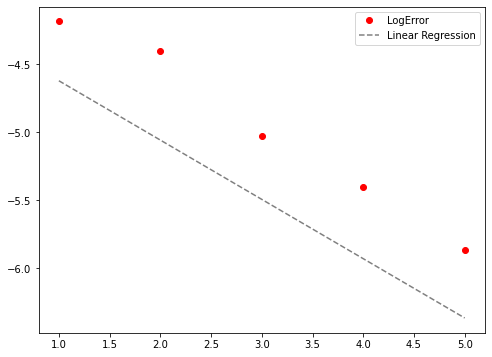



slope =  -0.4357319547618852


In [ ]:
beta = 0.8
mu_gamma = 0.6
sigma_1 = 0.05
sigma_2 = 0.3
N = 1

T = 20
I_0 = 0.6

slope(T, I_0, a_SIS, b1_SIS, b2_SIS, rand_euler_scheme_error, 100, 6)

### **Porównanie z klasycznym modelem SIS**

Klasyczny model SIS opisany jest następującym równaniem różniczkowym zwyczajnym:

$$dI(t) = [\beta (N-I)I(t) - (\mu + \gamma)I(t)]dt$$

z warunkiem początkowym $I(0) \in (0, N)$. Na poniższym wykresie zamieściłem przybliżone rozwiązanie klasycznego modelu SIS oraz modelu stochastycznego, aby zobaczyć jak dodane zaburzenia wpływają na model. Przy odpowiednich parametrach są one do siebie zbliżone.

N = 1
beta = 0.4
mu + gamma = 0.5
sigma_1 = 0.01
sigma_2 = 0.3
I_0 = 0.3




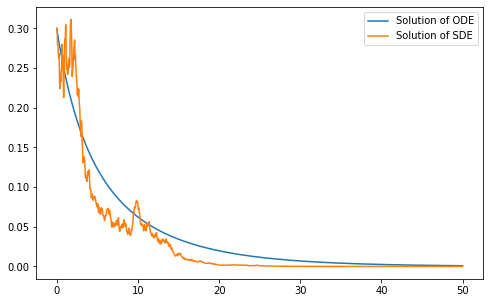

In [ ]:
N = 1
beta = 0.4
mu_gamma = 0.5
sigma_1 = 0.01
sigma_2 = 0.3
I_0 = 0.3

print('N = ' +str(N) + '\nbeta = ' +str(beta) + '\nmu + gamma = ' + str(mu_gamma) + '\nsigma_1 = ' + str(sigma_1) + '\nsigma_2 = ' + str(sigma_2) + '\nI_0 = ' +str(I_0))
print('\n')

T = 50
n = 10**3

# dla ODE b1 = 0, b2 = 0
b_0 = lambda t, x: 0
# ODE rozwiązane schematem eulera
Time_ode, I_ode = euler_scheme(T, I_0, a_SIS, b_0, b_0, n)

# SDE rozwiązane schematem eulera
Time, I = euler_scheme(T, I_0, a_SIS, b1_SIS, b2_SIS, n)

plt.figure(figsize=(8,5))
plt.plot(Time_ode, I_ode, label = 'Solution of ODE')
plt.plot(Time, I, label = 'Solution of SDE')
plt.legend()
plt.show()

### **Model SIS z różnymi paramterami**

**Twierdzenie** (*Wygasanie epidemii*)

Niech $R_0^S = \frac{\beta N}{\mu + \gamma} - \frac{\sigma_1^2 N^2 + \sigma_2^2 N^2}{2(\mu + \gamma)} < 1$. Wówczas dla dowolnego warunku początkowego $I(0) \in (0, N)$ rozwiązanie stochastycznego równania SIS wygasa wykładniczo z prawdopodobieństwem jeden, jeśli spełniony jest co najmniej jeden warunków:

*   $\sigma_1^2 N + \frac{1}{2} \sigma_2^2 \leq \beta$,

*   $\frac{1}{2} \sigma_2^2 \geq \beta$,

*   $(\beta - \sigma_1\sqrt{2(\mu + \gamma)}) \vee (\beta - \sigma_1^2 N) < \frac{1}{2}\sigma_2^2 < \beta$.

Oznacza to, że epidemia przy jednym z powyższych warunków wygasa.

##### **Gdy warunki na wygasanie są spełnione**

N = 1
beta = 0.45
mu + gamma = 0.45
sigma_1 = 0.1
sigma_2 = 0.03
I_0 = 0.3

R_0 =  0.9878888888888889

Euler scheme:


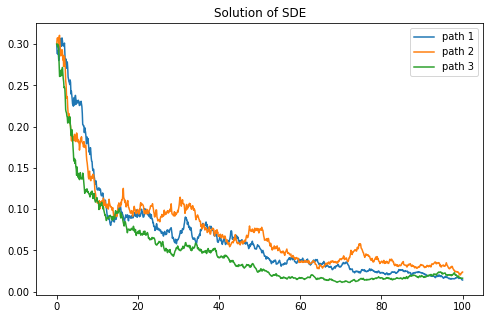


Random Euler scheme:


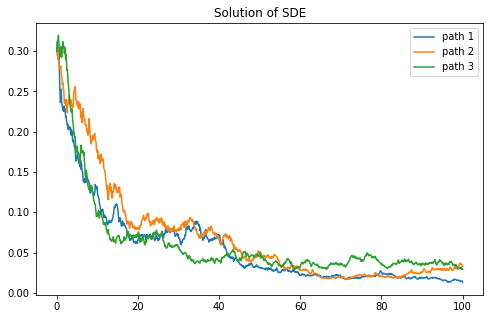

In [ ]:
N = 1
beta = 0.45
mu_gamma = 0.45
sigma_1 = 0.1
sigma_2 = 0.03
I_0 = 0.3

print('N = ' +str(N) + '\nbeta = ' +str(beta) + '\nmu + gamma = ' + str(mu_gamma) + '\nsigma_1 = ' + str(sigma_1) + '\nsigma_2 = ' + str(sigma_2) + '\nI_0 = ' +str(I_0))

R_0 = (beta*N)/(mu_gamma) - ((sigma_1*N)**2 + (sigma_2*N)**2)/(2*(mu_gamma))
print('\nR_0 = ', R_0)

T = 100
n = 10**3

print('\nEuler scheme:')
plot_paths(T, I_0, a_SIS, b1_SIS, b2_SIS, n, euler_scheme, 3)
print('\nRandom Euler scheme:')
plot_paths(T, I_0, a_SIS, b1_SIS, b2_SIS, n, rand_euler_scheme, 3)

##### **Gdy warunek $R_0^S < 1$ nie jest spełniony**

N = 1
beta = 0.75
mu + gamma = 0.4
sigma_1 = 0.5
sigma_2 = 0.03
I_0 = 0.3

R_0 =  1.561375

Euler scheme:


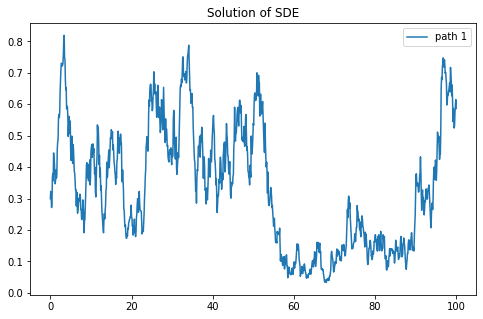


Random Euler scheme:


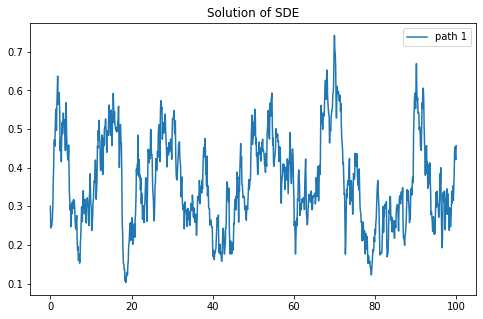

In [ ]:
N = 1
beta = 0.75
mu_gamma = 0.4
sigma_1 = 0.5
sigma_2 = 0.03
I_0 = 0.3

print('N = ' +str(N) + '\nbeta = ' +str(beta) + '\nmu + gamma = ' + str(mu_gamma) + '\nsigma_1 = ' + str(sigma_1) + '\nsigma_2 = ' + str(sigma_2) + '\nI_0 = ' +str(I_0))


R_0 = (beta*N)/(mu_gamma) - ((sigma_1*N)**2 + (sigma_2*N)**2)/(2*(mu_gamma))
print('\nR_0 = ', R_0)

T = 100
n = 10**3

print('\nEuler scheme:')
plot_paths(T, I_0, a_SIS, b1_SIS, b2_SIS, n, euler_scheme, 1)
print('\nRandom Euler scheme:')
plot_paths(T, I_0, a_SIS, b1_SIS, b2_SIS, n, rand_euler_scheme, 1)

##### **Gdy warunek na istnienie dokładnie jednego rozwiązania nie jest spełniony**

Przy poniższych parametrach rozwiązanie może nie należeć do $[0, N]$ lub może nie być jednoznaczne, dlatego często występują błąd związany z pierwiastkiem z równania.

N = 1
beta = 0.4
mu + gamma = 0.1
sigma_1 = 0.5
sigma_2 = 0.9
I_0 = 0.3

mu + gamma =  0.1
0.5*N*sigma^2 =  0.405



Euler scheme:


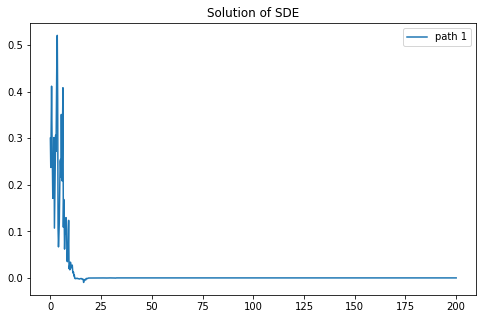


Random Euler scheme:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


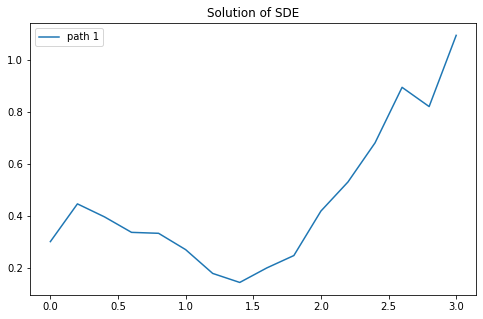

In [ ]:
N = 1
beta = 0.4
mu_gamma = 0.1
sigma_1 = 0.5
sigma_2 = 0.9
I_0 = 0.3

print('N = ' +str(N) + '\nbeta = ' +str(beta) + '\nmu + gamma = ' + str(mu_gamma) + '\nsigma_1 = ' + str(sigma_1) + '\nsigma_2 = ' + str(sigma_2) + '\nI_0 = ' +str(I_0))


print('\nmu + gamma = ', mu_gamma)
print('0.5*N*sigma^2 = ', 0.5*N*sigma_2**2)
print('\n')

T = 200
n = 10**3

print('\nEuler scheme:')
plot_paths(T, I_0, a_SIS, b1_SIS, b2_SIS, n, euler_scheme, 1)
print('\nRandom Euler scheme:')
plot_paths(T, I_0, a_SIS, b1_SIS, b2_SIS, n, rand_euler_scheme, 1)

##### **Kolejna własność $I(t)$**

**Twierdzenie**

Jeśli $R_0^S = \frac{\beta N}{\mu + \gamma} - \frac{\sigma_1^2 N^2 + \sigma_2^2 N^2}{2(\mu + \gamma)} > 1$, to dla dowolnego warunku początkowego $I(0) \in (0, N)$ rozwiązanie spełnia z prawdopodobieństwem jeden

$$\limsup\limits_{t \to \infty} I(t) \geq \xi \quad \text{oraz} \quad \liminf\limits_{t \to \infty} I(t) \leq \xi,$$

gdzie 

$$\xi = \frac{-\beta + \sigma_1^2 + \frac{1}{2}\sigma_2^2 + \sqrt{\beta^2 - \sigma_2^2\beta - 2\sigma_1^2(\mu + \gamma) + \frac{1}{4}\sigma_2^4}}{\sigma_1^2}.$$

Oznacza to, że prawie na pewno $I(t)$ będzie miało nieskończenie razy często wartości mniejsze oraz większe od $\xi$.

N = 1
beta = 0.5
mu + gamma = 0.45
sigma_1 = 0.04
sigma_2 = 0.03

R_0 =  1.1083333333333334

xi =  0.09788600193693514

I_0 =  0.3


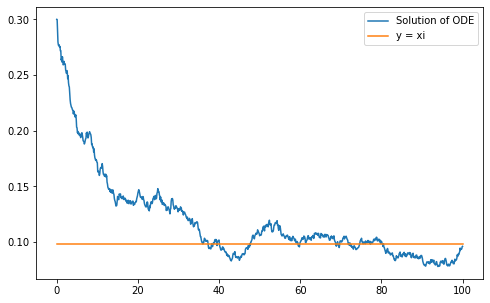


I_0 =  0.7


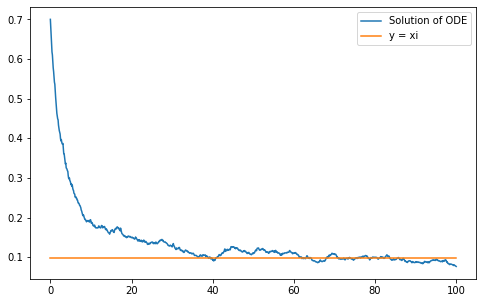

In [ ]:
N = 1
beta = 0.5
mu_gamma = 0.45
sigma_1 = 0.04
sigma_2 = 0.03
print('N = ' +str(N) + '\nbeta = ' +str(beta) + '\nmu + gamma = ' + str(mu_gamma) + '\nsigma_1 = ' + str(sigma_1) + '\nsigma_2 = ' + str(sigma_2))

R_0 = (beta*N)/(mu_gamma) - ((sigma_1*N)**2 + (sigma_2*N)**2)/(2*(mu_gamma))
print('\nR_0 = ', R_0)

xi = (-beta + N*sigma_1**2 + 0.5*sigma_2**2 + np.sqrt(beta**2 - beta*sigma_2**2 - 2*(sigma_1**2)*(mu_gamma)+ 0.25*sigma_2**4))/(sigma_1**2)
print('\nxi = ', xi)

T = 100
n = 10**3
I_0 = 0.3

I_0 = 0.3
print('\nI_0 = ', I_0)
Time, I = euler_scheme(T, I_0, a_SIS, b1_SIS, b2_SIS, n)
plt.figure(figsize=(8,5))
plt.plot(Time, I, label = 'Solution of ODE')
plt.plot(Time, [xi for t in Time], label = 'y = xi')
plt.legend()
plt.show()

I_0 = 0.7
print('\nI_0 = ', I_0)
Time, I = euler_scheme(T, I_0, a_SIS, b1_SIS, b2_SIS, n)
plt.figure(figsize=(8,5))
plt.plot(Time, I, label = 'Solution of ODE')
plt.plot(Time, [xi for t in Time], label = 'y = xi')
plt.legend()
plt.show()